In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
path ='/content/traffic.csv'
data = pd.read_csv(path,index_col = 'DateTime')

In [ ]:
data.head()


,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data.shape

(48120, 3)

In [ ]:
data.dtypes


Junction    int64
Vehicles    int64
ID          int64
dtype: object

In [ ]:
data = data[data['Junction']==1]

In [ ]:
data.shape

(14592, 3)

In [ ]:
data.isnull().sum()/data.count()*100

Junction    0.0
Vehicles    0.0
ID          0.0
dtype: float64

In [ ]:
def last_n_days(df, feature, n_days):
    """
    Extract last n_days of a time series
    """

    return df[feature][-(24*n_days):]

def plot_last_n_days(df, feature, n_days):
    """
    Plot last n_days of an hourly time series
    """
    plt.figure(figsize = (10,5))
    plt.plot(last_n_days(df, feature, n_days), 'k-')
    plt.title('{0} Time Series - {1} days'
              .format(feature, n_days))
    plt.xlabel('Recorded hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)


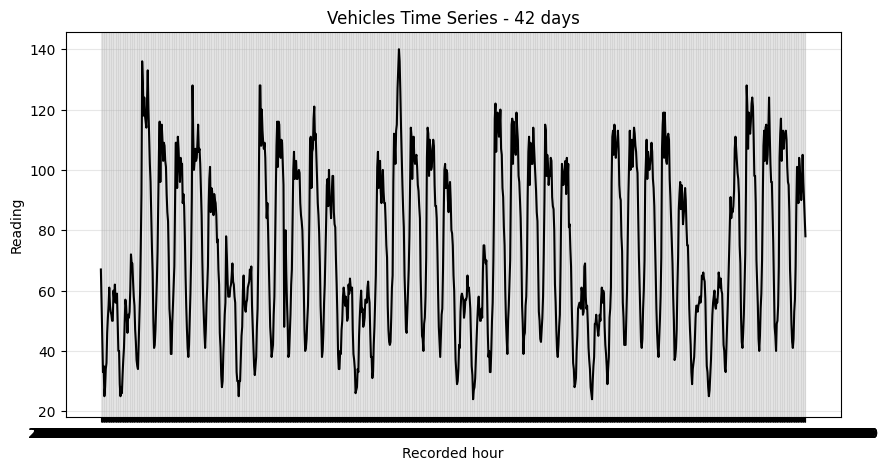

In [ ]:
plot_last_n_days(data, 'Vehicles', 42)

In [ ]:
def get_keras_format_series(series):
 series = np.array(series)
 return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours,
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into
    train and test with keras-friendly format, according to user-specified
    choice of shape.

    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5

    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y
    """

    forecast_series = last_n_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap.
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras

    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours]
    test_y = test[input_hours:] # test_y is remaining values from test set

    return train_X, test_X_init, train_y, test_y

In [ ]:
series_days = 72
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(data, 'Vehicles', series_days,
                         input_hours, test_hours))

In [ ]:
train_y.shape

(564,)

In [ ]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))



Training input shape: (564, 12, 1)
Training output shape: (564,)
Test input shape: (12,)
Test output shape: (12,)


In [ ]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
   model = Sequential()
   model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
   model.add(Dense(1))
   model.compile(loss='mean_squared_error', optimizer='adam')
   model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

   return model

In [ ]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)


In [ ]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series
    """

    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction

    preds = np.array(preds).reshape(-1,1)
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an  input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps

    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title
    """

    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours

    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')

    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 146ms/step


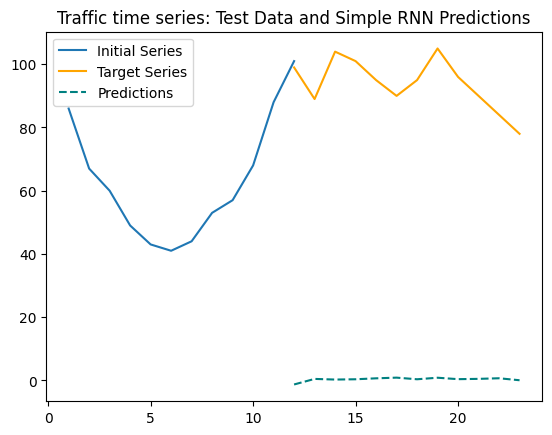

In [ ]:
predict_and_plot(test_X_init, test_y, model,
                 'Traffic time series: Test Data and Simple RNN Predictions')

1/1 [==============================] - 0s 26ms/step


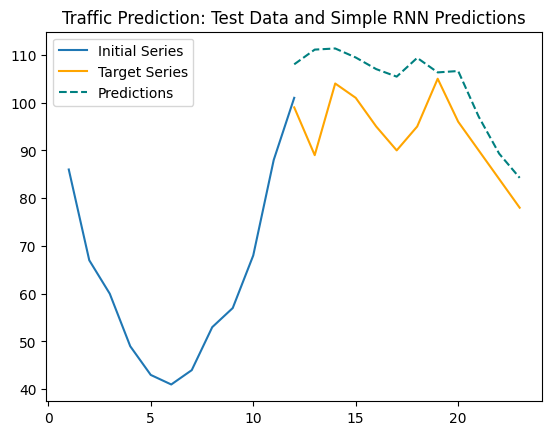

In [ ]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'Traffic Prediction: Test Data and Simple RNN Predictions')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

1/1 [==============================] - 0s 29ms/step


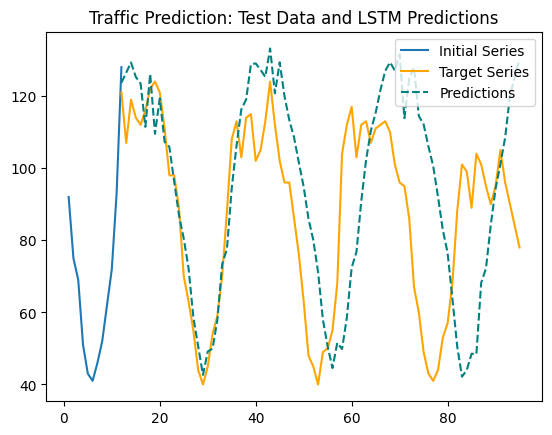

In [ ]:
series_days = 50
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(data, 'Vehicles', series_days,
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model,
                 'Traffic Prediction: Test Data and LSTM Predictions')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/content/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

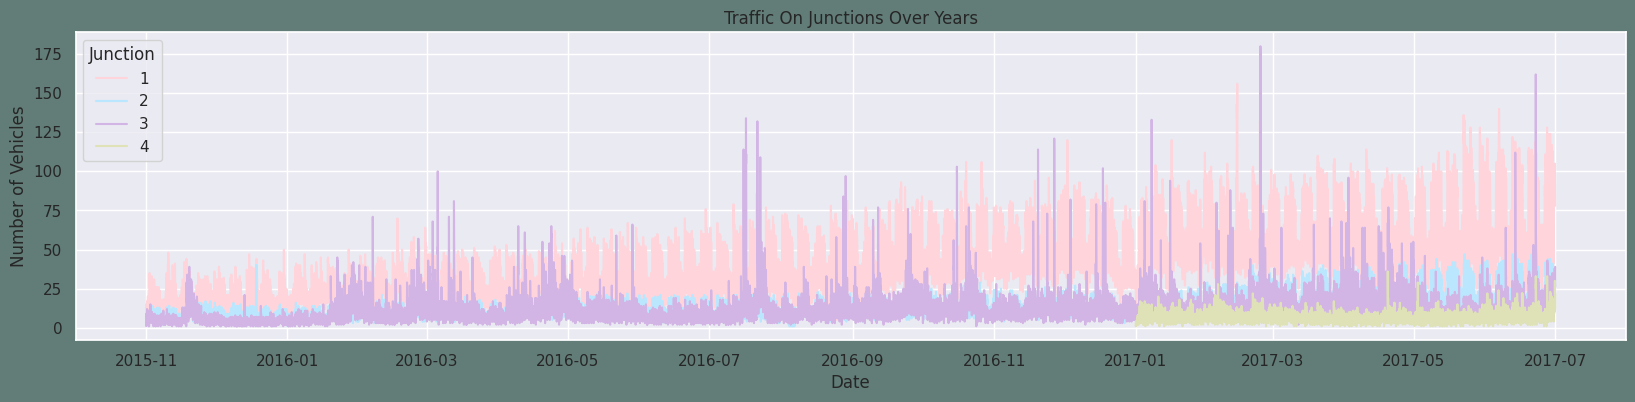

In [ ]:
sns.set_theme()

#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


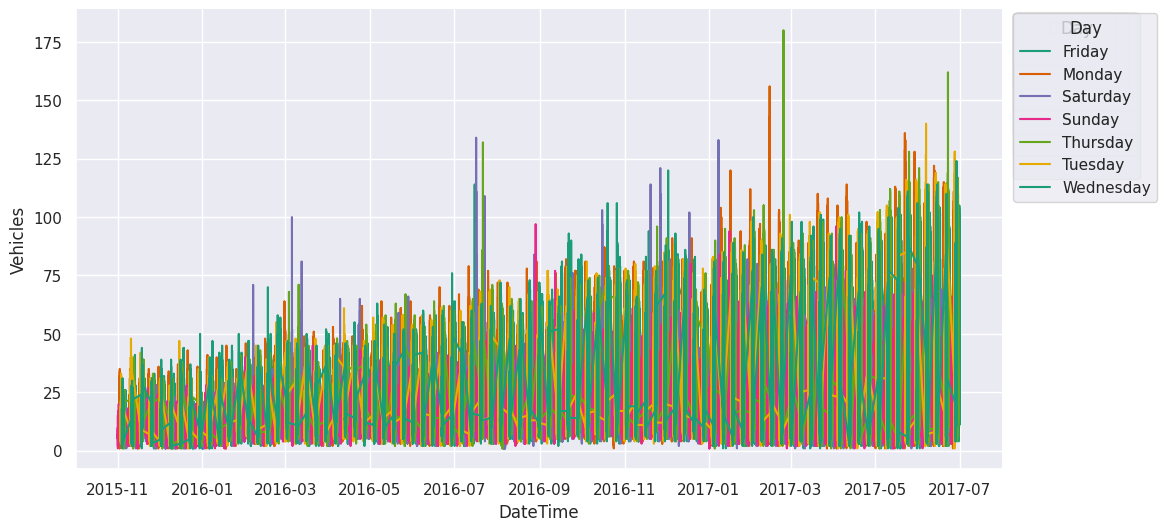

In [ ]:
# @title DateTime vs Vehicles

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DateTime']
  ys = series['Vehicles']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('DateTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Day')):
  _plot_series(series, series_name, i)
  fig.legend(title='Day', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DateTime')
_ = plt.ylabel('Vehicles')

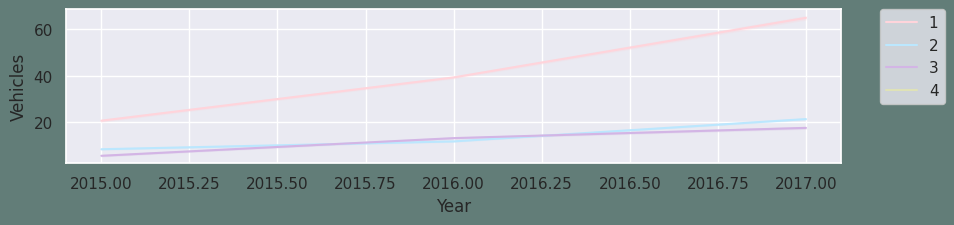

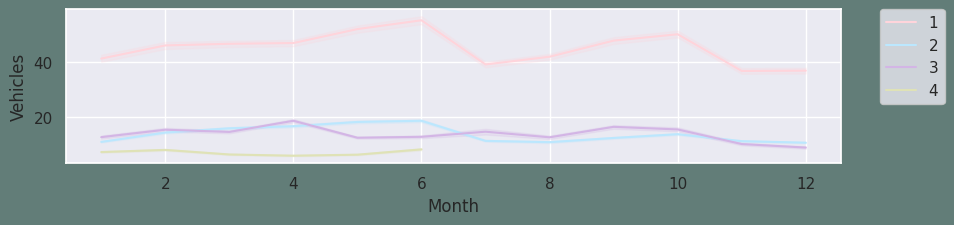

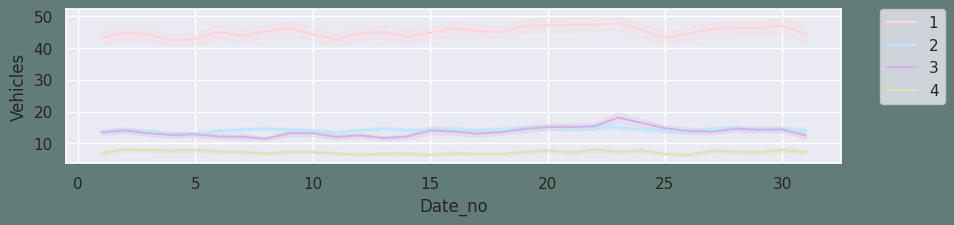

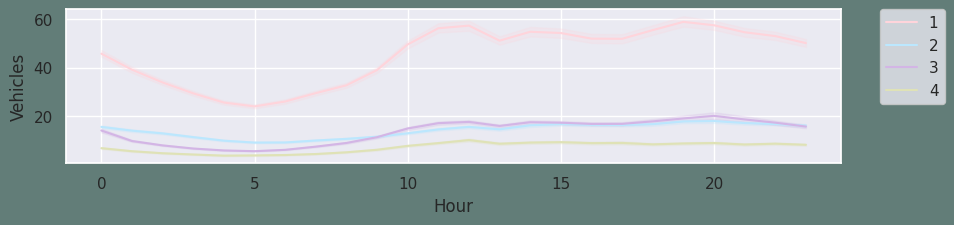

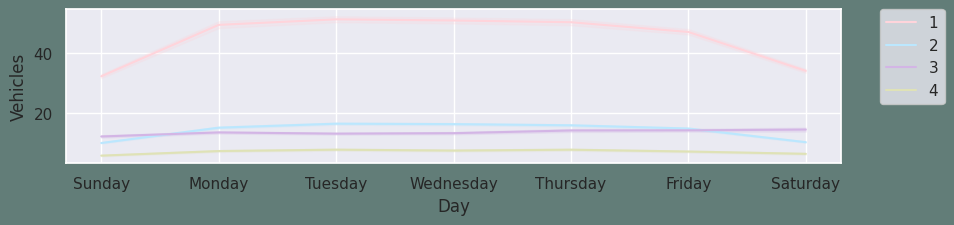

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

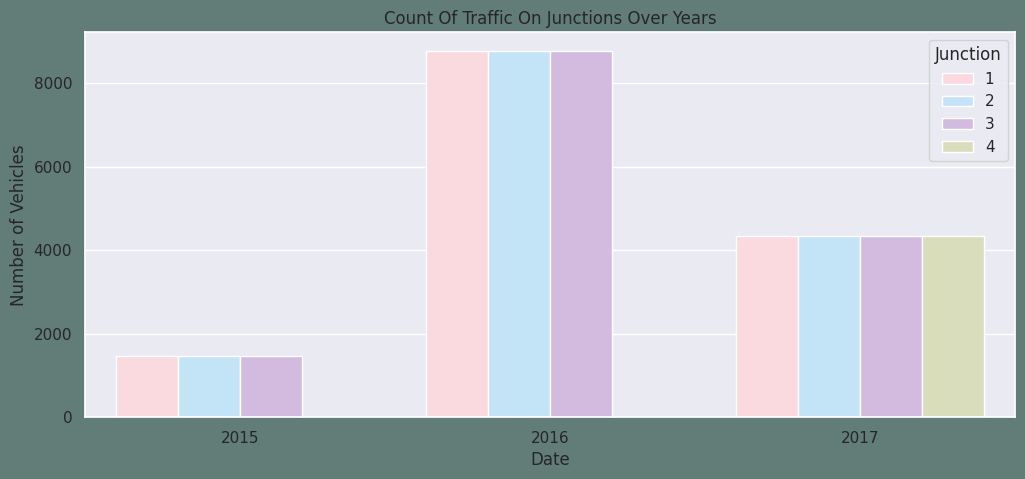

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

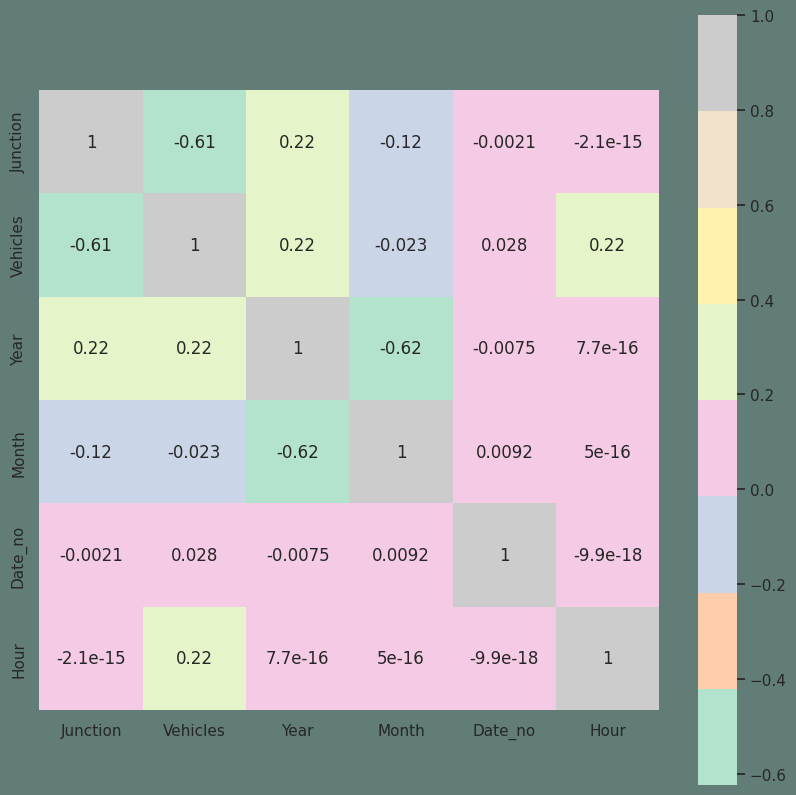

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

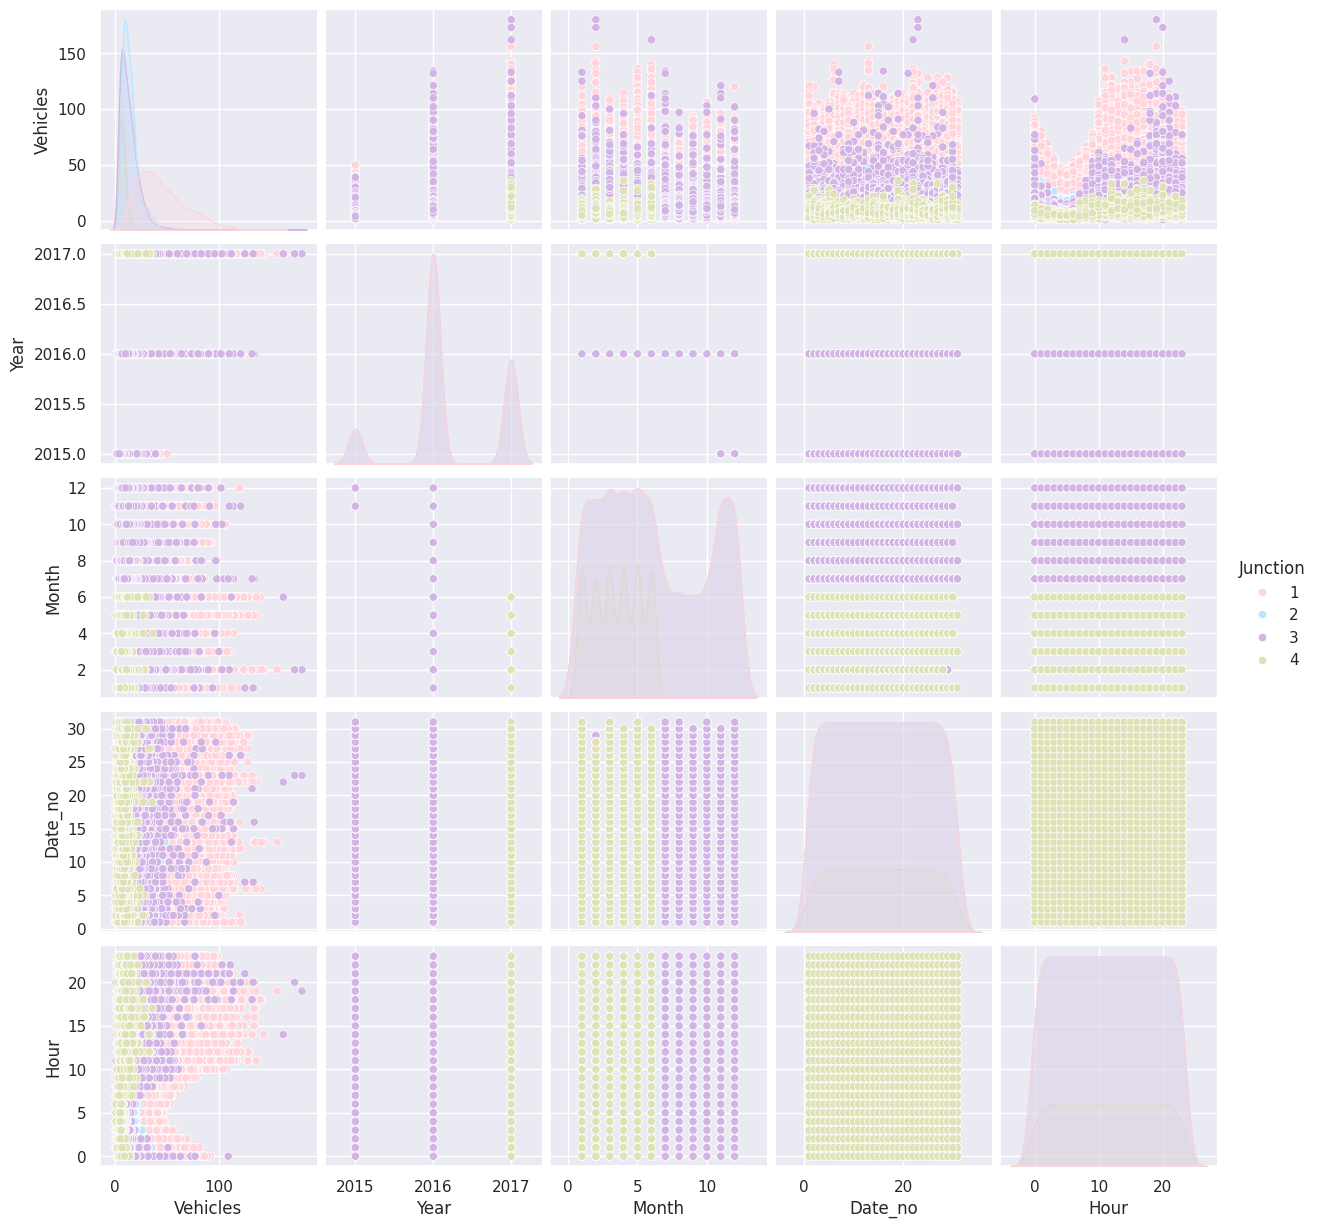

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [ ]:
df_J

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

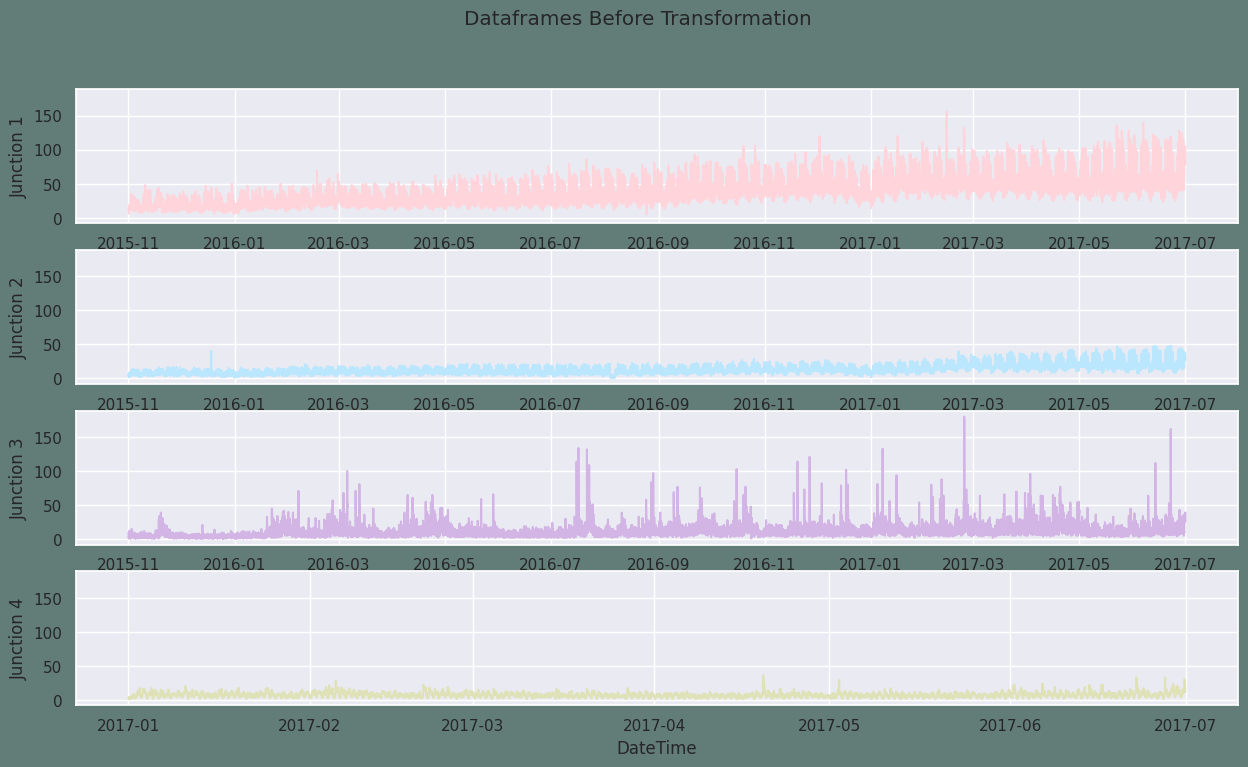

In [ ]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
# Normalize Function
#data Normalization
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df[ col ] = df_normalized
    df_normalized = df_normalized.to_frame()
    #df = df.to_frame()
    return df, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
df = df.set_index( ["DateTime"])

In [ ]:
df = df[ df[ "Junction" ] == 1]

In [ ]:
df

,Junction,Vehicles,Year,Month,Date_no,Hour,Day
DateTime,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,105,2017,6,30,19,Friday
2017-06-30 20:00:00,1,96,2017,6,30,20,Friday
2017-06-30 21:00:00,1,90,2017,6,30,21,Friday


In [ ]:
df[ "Day" ] = df[ "Day" ].astype( str ).replace( { "Monday" : 1 , "Tuesday" : 2 , "Wednesday" : 3 , "Thursday" : 4 , "Friday" : 5 , "Saturday" : 6 , "Sunday" : 7 } )

In [ ]:
df

,Junction,Vehicles,Year,Month,Date_no,Hour,Day
DateTime,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,7
2015-11-01 01:00:00,1,13,2015,11,1,1,7
2015-11-01 02:00:00,1,10,2015,11,1,2,7
2015-11-01 03:00:00,1,7,2015,11,1,3,7
2015-11-01 04:00:00,1,9,2015,11,1,4,7
...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,105,2017,6,30,19,5
2017-06-30 20:00:00,1,96,2017,6,30,20,5
2017-06-30 21:00:00,1,90,2017,6,30,21,5
